### Imports and load the data

In [1]:
from showupforhealth.utils import perform_train_test_split, scale_df
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import time
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from sklearn.metrics import f1_score
import keras_tuner as kt

/Users/alessio/.pyenv/versions/3.10.6/envs/showupforhealth/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
2023-09-15 23:17:03.082737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DL model

### Load and shuffle the data

In [2]:
data = pd.read_csv('/Users/alessio/code/janduplessis883/data-showup/data/output-data/full_train_data.csv')

In [3]:
data = data.sample(frac = 1)
data['Appointment_status'].value_counts()

1    867132
0     34384
Name: Appointment_status, dtype: int64

In [4]:
filt_sex_1 = (data['Sex'] != 1)
data = data[filt_sex_1]

In [5]:
filt_sex_2 = (data['Sex'] != 3)
data = data[filt_sex_2]
data['Sex'].value_counts()

0    571356
2    330086
Name: Sex, dtype: int64

In [6]:
data_dna = data[data['Appointment_status']==0]
data_dna.shape

(34381, 37)

In [28]:
data_no_dna = data[data['Appointment_status']==1][:80000]
data_no_dna.shape

(80000, 37)

In [29]:
data_balanced = pd.concat([data_dna, data_no_dna]).sample(frac = 1)
data_balanced['Appointment_status'].value_counts()

1    80000
0    34381
Name: Appointment_status, dtype: int64

In [30]:
data_balanced.head(20)

,Appointment_status,temp,precipitation,Age,Sex,FRAILTY,DEPRESSION,OBESITY,IHD,DM,...,No_shows,Rota_ARRS,Rota_GP,Rota_HCA,Rota_Nurse,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed,Ethnicity_Other,Ethnicity_White
292120,0,29.7,0.0,54,0,0.03,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
410054,1,20.0,0.0,79,2,0.06,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
404255,1,21.6,0.0,67,2,0.11,1,0,0,0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
127677,0,11.3,0.0,19,0,0.00,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
47921,0,12.7,0.0,55,0,0.03,0,0,0,0,...,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
34150,1,20.2,0.0,67,0,0.22,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
413285,1,12.7,0.0,84,0,0.22,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
640739,1,14.8,0.0,62,0,0.25,1,1,0,0,...,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
318013,1,19.5,0.0,72,0,0.33,0,0,1,1,...,14.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
364268,1,4.4,0.0,52,0,0.25,1,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split in X and y

In [31]:
X = data_balanced.drop(columns=['Appointment_status'])
y = data_balanced['Appointment_status']

### Baseline accuracy

In [32]:
print(f'The baseline accuracy if we assume that all patients will show-up is {y.value_counts()[1] / X.shape[0]}')

The baseline accuracy if we assume that all patients will show-up is 0.6994168611919812


### Split in Train and Test

In [33]:
X_train, X_test, y_train, y_test = perform_train_test_split(X,y)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (91504, 36), (91504,)
 Test Set:  X_test, y_test - - (22877, 36), (22877,)


In [13]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(sampling_strategy=0.3)

# X_train_u, y_train_u = rus.fit_resample(X_train, y_train)

# y_train_u.value_counts()

### Scale X_train and X_test

In [34]:
def mm_scaler(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = mm_scaler(X_train, X_test)

### Split Train and Validation

In [35]:
X_train_val, X_val, y_train_val, y_val = perform_train_test_split(X_train_scaled, y_train)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (73203, 36), (73203,)
 Test Set:  X_test, y_test - - (18301, 36), (18301,)


# Model

In [36]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.AUC(name='auc')]

### Model 1

In [123]:
%%time
model = Sequential()
es = EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

model.add(layers.Dense(256, activation='relu', input_dim=X.shape[1]))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history = model.fit(X_train_val, y_train_val,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=300,
                    shuffle=True,
                    callbacks=[es],
                    verbose=0)

results = model.evaluate(X_test_scaled, y_test)

653/653 [==============================] - 1s 1ms/step - loss: 0.3496 - accuracy: 0.8345 - recall: 0.8437 - precision: 0.9030 - auc: 0.9106
CPU times: user 4min 30s, sys: 59.1 s, total: 5min 29s
Wall time: 2min 33s


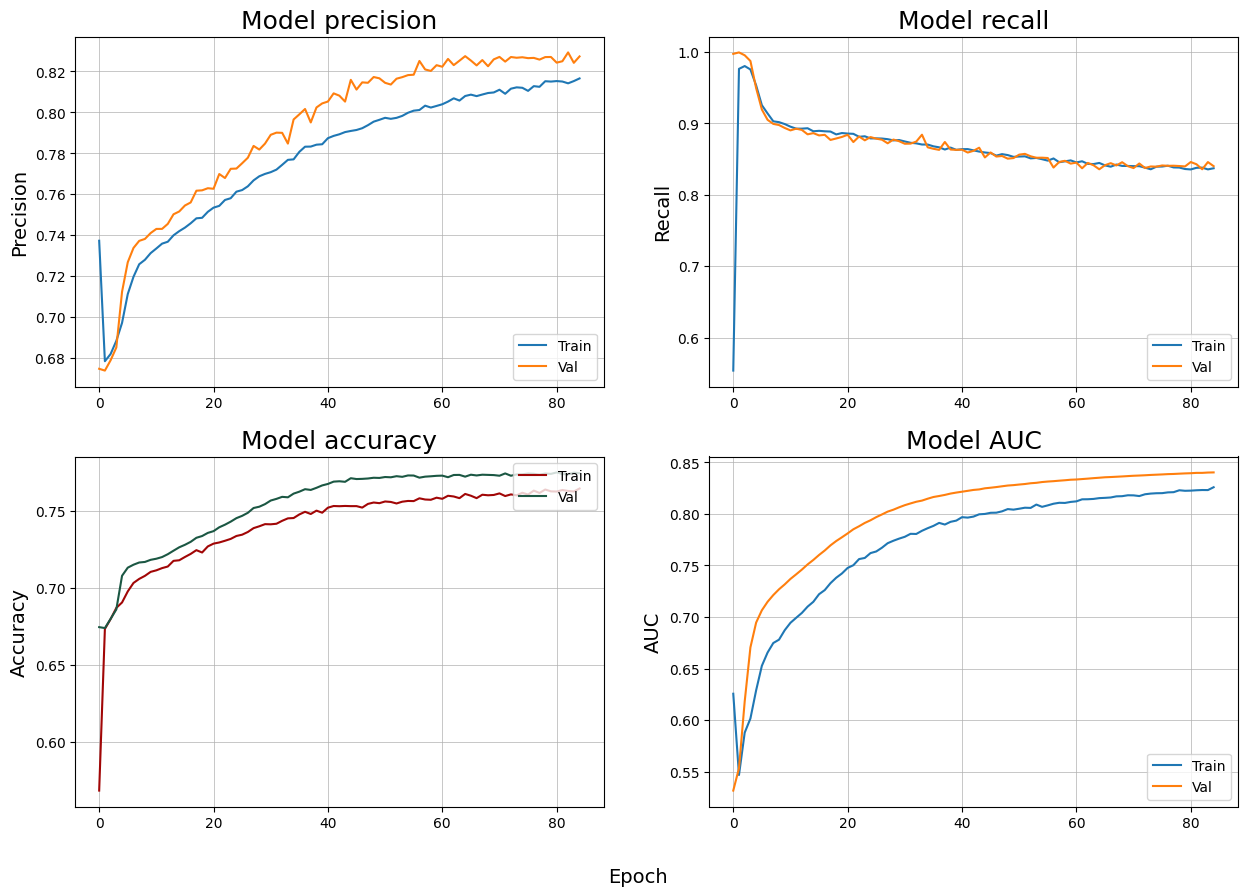

In [151]:
plot_loss_precision_recall_curve(history)

### Model 2

In [157]:
%%time
model = Sequential()

es = EarlyStopping(patience=20, monitor='val_recall', restore_best_weights=True)

model.add(layers.Dense(128, activation='relu', input_dim=X.shape[1]))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history = model.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    batch_size=128,
                    epochs=300,
                    shuffle=True,
                    callbacks=[es],
                    verbose=0)

results = model.evaluate(X_test_scaled, y_test)

653/653 [==============================] - 1s 1ms/step - loss: 0.4429 - accuracy: 0.7833 - recall: 0.8353 - precision: 0.8403 - auc: 0.8522
CPU times: user 1min 7s, sys: 15.6 s, total: 1min 22s
Wall time: 38.4 s


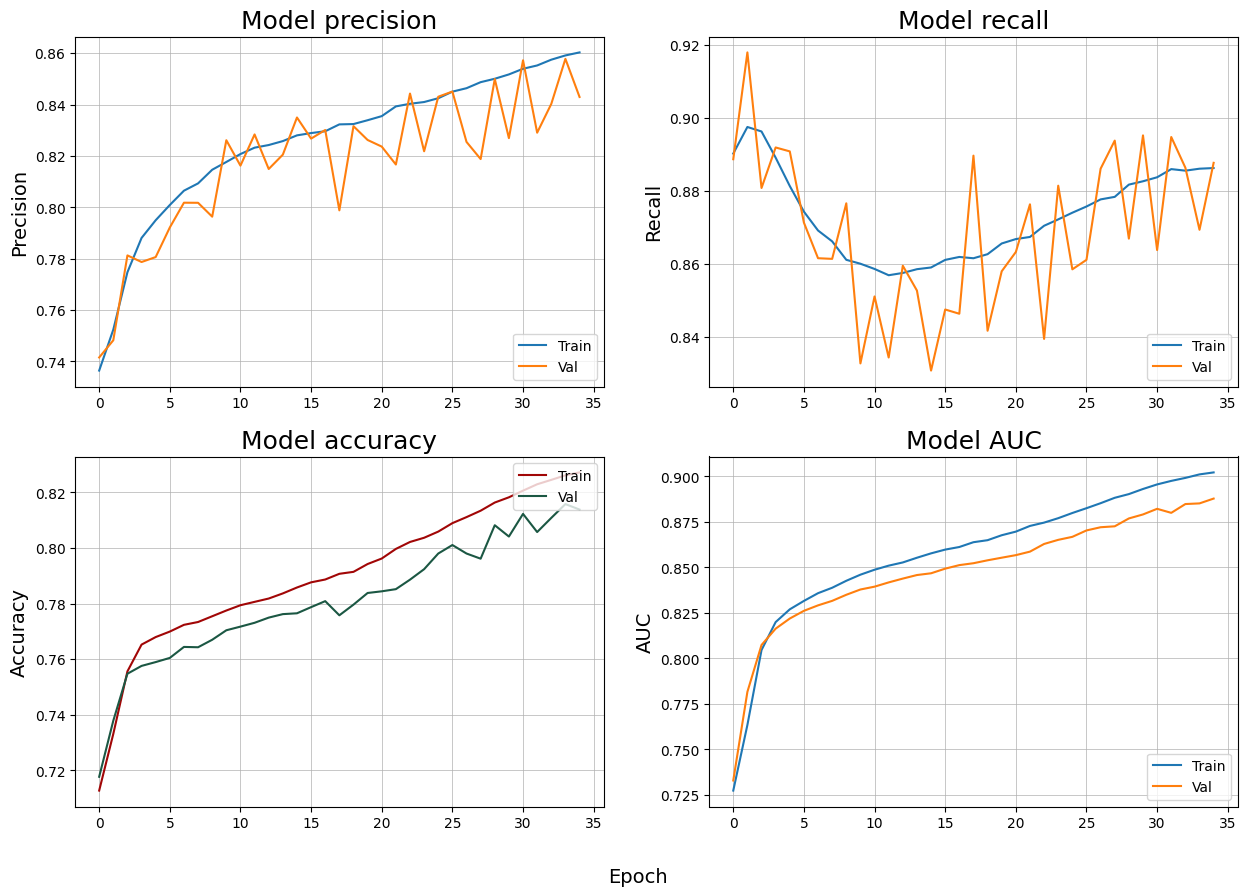

In [159]:
plot_loss_precision_recall_curve(history)

### Model 3

In [212]:
%%time
model = Sequential()

# es = EarlyStopping(patience=10, monitor='val_recall', restore_best_weights=True)
# callbacks=[es]

model.add(layers.Dense(64, activation='relu', input_dim=X.shape[1]))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history = model.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=300,
                    shuffle=True,
                    verbose=0)

results = model.evaluate(X_test_scaled, y_test)

653/653 [==============================] - 1s 1ms/step - loss: 0.3531 - accuracy: 0.8336 - recall: 0.8618 - precision: 0.8874 - auc: 0.9088
CPU times: user 18min 38s, sys: 3min 21s, total: 21min 59s
Wall time: 13min 11s


### Baseline

In [211]:
print(f'Val Recall is {history.history["val_recall"][-1]}')
print(f'Val Precision is {history.history["val_precision"][-1]}')

Val Recall is 0.8610422015190125
Val Precision is 0.8935896158218384


### Model 4

In [18]:
%%time
model = Sequential()
es = EarlyStopping(patience=20, monitor='val_recall', restore_best_weights=True)

model.add(layers.Dense(16, activation='relu', input_dim=X.shape[1]))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history = model.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=300,
                    shuffle=True,
                    callbacks=[es],
                    verbose=0)
results = model.evaluate(X_test_scaled, y_test)

653/653 [==============================] - 1s 1ms/step - loss: 0.4371 - accuracy: 0.7840 - recall: 0.8332 - precision: 0.8420 - auc: 0.8577
CPU times: user 3min 13s, sys: 28.7 s, total: 3min 42s
Wall time: 2min 20s


In [26]:
len(history.history['accuracy'])

58

In [19]:
print(f'Val Recall is {history.history["val_recall"][-1]}')
print(f'Val Precision is {history.history["val_precision"][-1]}')
print(f'Val Accuracy is {history.history["val_accuracy"][-1]}')

Val Recall is 0.8629745244979858
Val Precision is 0.8612052202224731
Val Accuracy is 0.8149212598800659


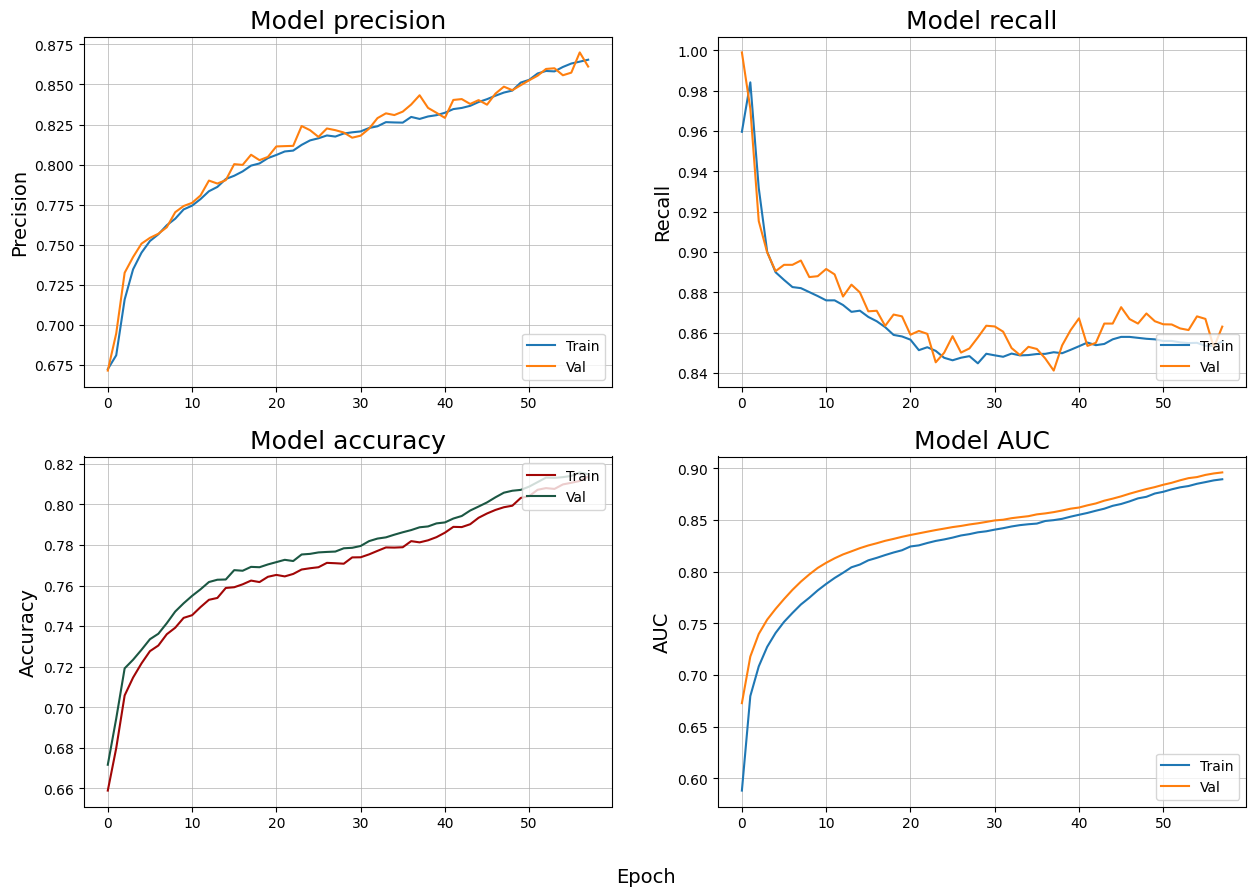

In [22]:
plot_loss_precision_recall_curve(history)

### Plot curves function

In [23]:
def plot_loss_precision_recall_curve(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        # --- ACCURACY 
    ax[1, 0].plot(history.history['accuracy'], color="#a10606")
    ax[1, 0].plot(history.history['val_accuracy'], color="#1b5743")
    ax[1, 0].set_title('Model accuracy', fontsize = 18)
    ax[1, 0].set_ylabel('Accuracy', fontsize = 14)
    ax[1, 0].legend(['Train', 'Val'], loc='upper right')
    ax[1, 0].grid(axis="x", linewidth=0.5)
    ax[1, 0].grid(axis="y", linewidth=0.5)
    
    # --- LOSS 
#     ax[0, 0].plot(history.history['loss'], color="#a10606")
#     ax[0, 0].plot(history.history['val_loss'], color="#1b5743")
#     ax[0, 0].set_title('Model loss', fontsize = 18)
#     ax[0, 0].set_ylabel('Loss', fontsize = 14)
#     ax[0, 0].legend(['Train', 'Val'], loc='upper right')
#     ax[0, 0].grid(axis="x", linewidth=0.5)
#     ax[0, 0].grid(axis="y", linewidth=0.5)

#     --- RECALL
    ax[0, 1].plot(history.history['recall']) 
    ax[0, 1].plot(history.history['val_recall'])
    ax[0, 1].set_title('Model recall', fontsize = 18)
    ax[0, 1].set_ylabel('Recall', fontsize = 14) 
    ax[0, 1].legend(['Train', 'Val'], loc='lower right')
    ax[0, 1].grid(axis="x", linewidth=0.5)
    ax[0, 1].grid(axis="y", linewidth=0.5)

#     --- PRECISION
    ax[0,0].plot(history.history['precision'])
    ax[0,0].plot(history.history['val_precision'])
    ax[0,0].set_title('Model precision', fontsize = 18)
    ax[0,0].set_ylabel('Precision', fontsize = 14)
    ax[0,0].legend(['Train', 'Val'], loc='lower right')
    ax[0,0].grid(axis="x", linewidth=0.5)
    ax[0,0].grid(axis="y", linewidth=0.5)
    
    # --- AUC
    ax[1, 1].plot(history.history['auc'])
    ax[1, 1].plot(history.history['val_auc'])
    ax[1, 1].set_title('Model AUC', fontsize = 18) 
    ax[1, 1].set_ylabel('AUC', fontsize = 14)
    ax[1, 1].legend(['Train', 'Val'], loc='lower right')
    ax[1, 1].grid(axis="x", linewidth=0.5)
    ax[1, 1].grid(axis="y", linewidth=0.5)

    # Set common labels  
    fig.text(0.5, 0.04, 'Epoch', ha='center', va='center', fontsize=14) 
    plt.show()

### Keras tuner Model 1

In [39]:
def model_builder(hp):
    model = Sequential()
    # hp
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=256, step=16)
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=256, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    # Layers
    model.add(layers.Dense(units=hp_units_1, activation='relu', input_dim=X.shape[1]))
    model.add(layers.Dense(units=hp_units_2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compiler
    adam = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=metrics)

    return model

In [41]:
LOG_DIR = f'{int(time.time())}'
tuner_kt_1 = kt.RandomSearch(model_builder,
                     objective=kt.Objective('val_auc', direction="max"),
                     directory=LOG_DIR)

stop_early = EarlyStopping(monitor='val_auc', patience=50, restore_best_weights=True)
                     
tuner_kt_1.search(X_train_val, y_train_val, validation_data=(X_val, y_val),
             epochs=50,
             callbacks=[stop_early])

Trial 6 Complete [00h 02m 59s]
val_auc: 0.8915767669677734

Best val_auc So Far: 0.9144769310951233
Total elapsed time: 00h 19m 03s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
192               |16                |units_1
80                |48                |units_2
0.001             |0.001             |learning_rate

Epoch 1/50
2288/2288 [==============================] - 5s 2ms/step - loss: 0.4772 - accuracy: 0.7766 - recall: 0.8725 - precision: 0.8202 - auc: 0.8243 - val_loss: 0.4350 - val_accuracy: 0.7831 - val_recall: 0.8750 - val_precision: 0.8275 - val_auc: 0.8445
Epoch 2/50
2200/2288 [===========================>..] - ETA: 0s - loss: 0.4367 - accuracy: 0.7847 - recall: 0.8772 - precision: 0.8262 - auc: 0.8445

KeyboardInterrupt: 

In [27]:
best_hps=tuner_kt_1.get_best_hyperparameters(num_trials=1)[0]
best_hps.__dict__

{'_name_scopes': [],
 '_conditions': [],
 '_hps': defaultdict(list,
             {'units_1': [Int(name: 'units_1', min_value: 16, max_value: 32, step: 16, sampling: linear, default: 16)],
              'units_2': [Int(name: 'units_2', min_value: 16, max_value: 32, step: 16, sampling: linear, default: 16)],
              'learning_rate': [Choice(name: 'learning_rate', values: [0.1, 0.01, 0.001, 0.0001], ordered: True, default: 0.1)]}),
 '_space': [Int(name: 'units_1', min_value: 16, max_value: 32, step: 16, sampling: linear, default: 16),
  Int(name: 'units_2', min_value: 16, max_value: 32, step: 16, sampling: linear, default: 16),
  Choice(name: 'learning_rate', values: [0.1, 0.01, 0.001, 0.0001], ordered: True, default: 0.1)],
 'values': {'units_1': 32,
  'units_2': 16,
  'learning_rate': 0.01,
  'tuner/epochs': 20,
  'tuner/initial_epoch': 7,
  'tuner/bracket': 2,
  'tuner/round': 2,
  'tuner/trial_id': '0014'},
 'active_scopes': [],
 'inactive_scopes': []}

In [20]:
es = EarlyStopping(patience=20, monitor='val_auc', restore_best_weights=True)
model_kt_1 = tuner_kt_1.hypermodel.build(best_hps)
history_kt_1 = model_kt_1.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    callbacks=[es])

In [21]:
model_kt_1.evaluate(X_test_scaled, y_test)

590/590 [==============================] - 1s 1ms/step - loss: 0.3525 - accuracy: 0.8357 - recall: 0.8412 - precision: 0.8931 - auc: 0.9120


[0.3525368869304657,
 0.8356730341911316,
 0.8412246704101562,
 0.8930728435516357,
 0.9119860529899597]

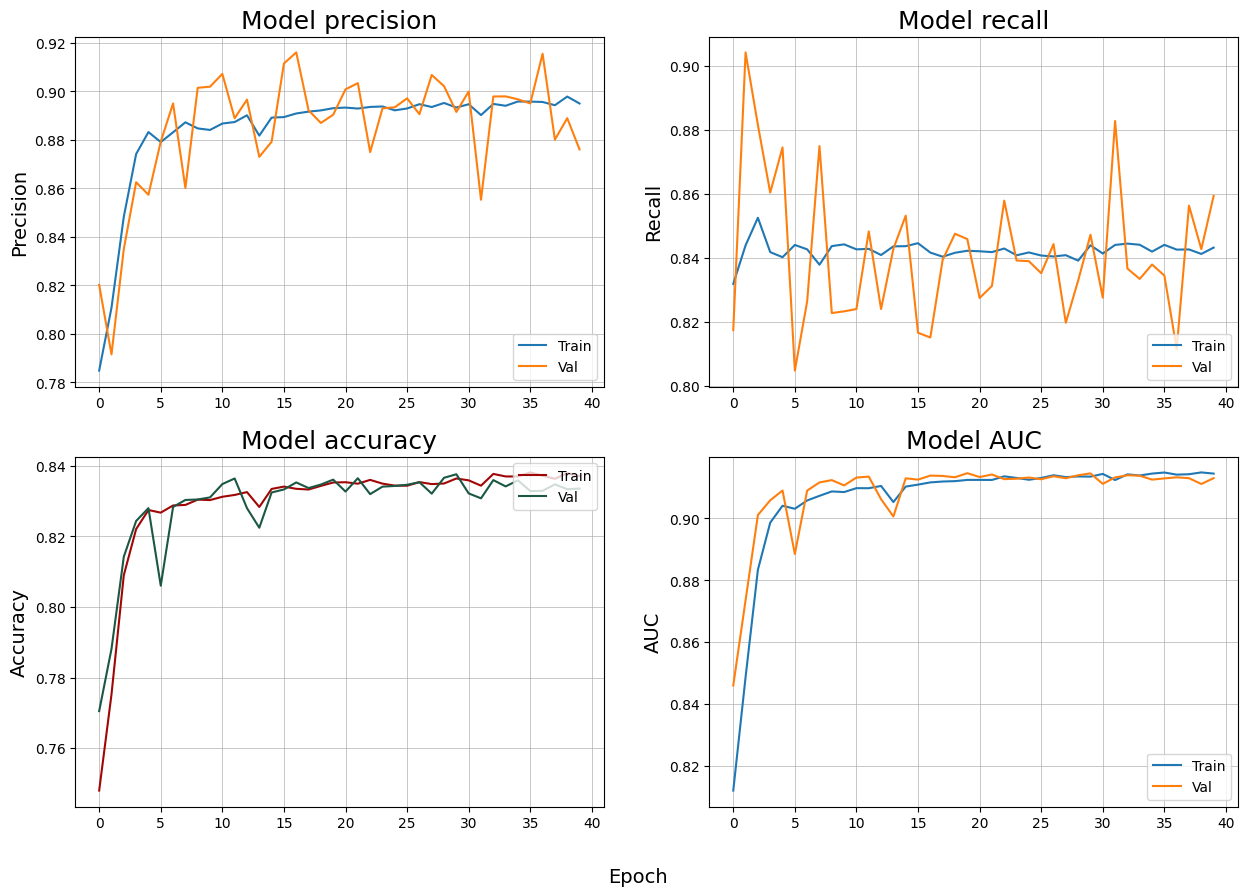

In [24]:
plot_loss_precision_recall_curve(history_kt_1)